In [1]:
def send_radial_gaia_query(query_size=1000000, distance=200, **kwargs):
    """
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """
    from astroquery.utils.tap.core import TapPlus

    gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")

    job = gaia.launch_job_async("select top {}".format(query_size)+
                #" lum_val, teff_val,"
                #" ra, dec, parallax,"
                " bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg"
         " from gaiadr2.gaia_source"
         " where parallax_over_error > 10"
         " and visibility_periods_used > 8"
         " and phot_g_mean_flux_over_error > 50"
         " and phot_bp_mean_flux_over_error > 20"
         " and phot_rp_mean_flux_over_error > 20"
         " and phot_bp_rp_excess_factor <"
            " 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and phot_bp_rp_excess_factor >"
            " 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<"
            "1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
         +" and 1000/parallax <= {}".format(distance), **kwargs)

    return job

In [3]:
# the query runs for a while, better ensure we have those data saved
import numpy as np
from astropy import log

try:
    log.info("Getting the DR2 results on nearby (d < 200 pc) stars...")
    gaiarec = np.recfromcsv("gaia-hrd-dr2-200pc.csv")
    bp_rp, mg = gaiarec.bp_rp, gaiarec.mg
except OSError:
    job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
                                 output_file="gaia-hrd-dr2-200pc.csv",
                                 query_size=10000000)
    r = job.get_results()
    bp_rp = r['bp_rp'].data
    mg = r['mg'].data

INFO: Getting the DR2 results on nearby (d < 200 pc) stars... [unknown]


/Users/vsokolov/Library/Python/3.6/lib/python/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0
/Users/vsokolov/Library/Python/3.6/lib/python/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0
/Users/vsokolov/Library/Python/3.6/lib/python/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


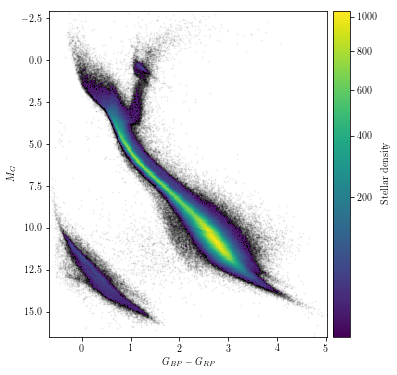

In [4]:
# plot the H-R diagram for 1 M stars within 200 pc from the Sun
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp, mg, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
plt.savefig("gaia-hrd-dr2.png", dpi=140)